In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import path, getcwd

In [2]:
# Import the Inception Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = f'{getcwd()}/PreTrained_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150 ,150 , 3), include_top=False, weights=None)

pre_trained_model.load_weights(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')    
print('Last Layer Output Shape: ', last_layer.output_shape)
last_output = last_layer.output

Last Layer Output Shape:  (None, 7, 7, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLu activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = f'{getcwd()}'

train_dir = os.path.join(base_dir, 'horse-or-human')
validation_dir = os.path.join(base_dir, 'validation-horse-or-human')

train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training cat pictures
train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training dog pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation cat pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation dog pictures

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [9]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [13]:
callbacks = myCallback()
history = model.fit(train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 52,
            epochs = 20,
            validation_steps = 13,
            verbose = 2,
            callbacks=[callbacks])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 13 steps
Epoch 1/20
52/52 - 44s - loss: 0.1132 - accuracy: 0.9640 - val_loss: 0.0037 - val_accuracy: 0.9961
Epoch 2/20
52/52 - 41s - loss: 0.0444 - accuracy: 0.9815 - val_loss: 0.0593 - val_accuracy: 0.9805
Epoch 3/20
52/52 - 41s - loss: 0.1147 - accuracy: 0.9640 - val_loss: 1.4231e-04 - val_accuracy: 1.0000
Epoch 4/20
52/52 - 41s - loss: 0.0577 - accuracy: 0.9805 - val_loss: 8.9601e-05 - val_accuracy: 1.0000
Epoch 5/20
52/52 - 41s - loss: 0.0554 - accuracy: 0.9805 - val_loss: 0.0328 - val_accuracy: 0.9883
Epoch 6/20
52/52 - 41s - loss: 0.0496 - accuracy: 0.9844 - val_loss: 0.0625 - val_accuracy: 0.9883
Epoch 7/20
52/52 - 41s - loss: 0.0498 - accuracy: 0.9854 - val_loss: 0.0211 - val_accuracy: 0.9883
Epoch 8/20
52/52 - 41s - loss: 0.0385 - accuracy: 0.9883 - val_loss: 0.0029 - val_accuracy: 0.9961
Epoch 9/20
52/52 - 41s - loss: 0.0241 - accuracy: 0.9903 - val_loss: 0.0050 - val_accuracy: 0.9961
Epoch 10/

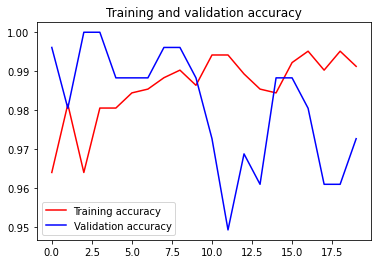

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()